In [1]:
%run init_notebook.py

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

## Main expressions

In [3]:
params = sp.symbols(['kbar', 'w_t', 'c_t', 's_t', 'k_t', 'N_t', 'k_{t+1}', 'N_{t+1}', 'd_{t+1}', 'R_{t+1}', 'beta', 'n', 'K_t', 'L_t', 'psi', 'alpha', 'X'])
kss, w, c, s, k, N, k1, N1, d, R, beta, n, K, L, psi, alpha, X = params

# for i in _:
    # display(i)

In [4]:
def assert_unique_solution(funcs: list):     
    assert type(funcs[0]) == list, "Need to feed nested list to funcs argument"
    
    for i, func in enumerate(funcs):
        assert len(func) == 1, f'Non unique solution for {display(func)}'
        funcs[i] = func[0]
        
    if len(funcs) == 1:
        return funcs[0]
    else:
        return funcs

In [5]:
# utility func
u = sp.Function('u')(sp.log(c) + beta * sp.log(d) + X)
F = sp.Function('F')(X * K**alpha * L**(1-alpha))
f = X * k**alpha

## budget constraint
b1 = sp.Eq(c + s, w)
b2 = sp.Eq(d, s * R)
# solve budget constraint for c and d
b1_c = sp.solve(b1, c)
b2_d = sp.solve(b2, d)
b1_c, b2_d = assert_unique_solution([b1_c, b2_d])

## get s_opt
# replace c and d by expressions of x
max_u = u.subs(c, b1_c)
max_u = max_u.subs(d, b2_d)
# get optimal response s

s_opt = sp.solve(max_u.diff(s), s)
s_opt = assert_unique_solution([s_opt])
c_opt = sp.solve(b1.subs(s, s_opt), c)
d_opt = sp.solve(b2.subs(s, s_opt), d)

c_opt, d_opt = assert_unique_solution([c_opt, d_opt])

## firm problem
w_f = f - f.diff(k) * k
R_f = f.diff(k)
# repalce wt and Rt+1 with values from firm problem
s_optf = s_opt.subs(w, w_f)
c_optf = c_opt.subs(w, w_f)
d_optf = d_opt.subs(w, w_f).subs(R, R_f)


## get k_ss
# get law of motion for k
k_motion = sp.Eq(k1, s * 1/(1+n))
k_motionf = k_motion.subs(s, s_optf).args[1]
# get steady state for k+1 = k, off law of motion
k_ss = k_motion.subs(s, s_optf)
k_ss = sp.solve(k_ss.subs(k, kss).subs(k1, kss), kss)
k_ss = assert_unique_solution([k_ss])

## get k_gold
psi = f - s

k_gold = sp.solve(k_motion, s)
k_gold = assert_unique_solution([k_gold])

k_gold = psi.subs(s, k_gold).subs(k1, kss).subs(k, kss)
k_gold = sp.solve(k_gold.diff(kss), kss)
k_gold = assert_unique_solution([k_gold])

## get k_ss stability

k_stable = k_motion.subs(s, s_optf).args[1]
k_stable = k_stable.diff(k)
k_stable = k_stable.subs(k, k_ss)
k_stable = sp.simplify(k_stable)

In [6]:
display(k_motionf, s_optf, c_optf, d_optf)

beta*(-X*alpha*k_t**alpha + X*k_t**alpha)/((beta + 1)*(n + 1))

beta*(-X*alpha*k_t**alpha + X*k_t**alpha)/(beta + 1)

(-X*alpha*k_t**alpha + X*k_t**alpha)/(beta + 1)

X*alpha*beta*k_t**alpha*(-X*alpha*k_t**alpha + X*k_t**alpha)/(k_t*(beta + 1))

In [7]:
params_sim = [beta, X, alpha, k, n]

make_kmotion = sp.lambdify(params_sim, k_motionf)
make_sopt = sp.lambdify(params_sim, s_optf)
make_copt = sp.lambdify(params_sim, c_optf)
make_dopt = sp.lambdify(params_sim, d_optf)

make_kss = sp.lambdify(params_sim, k_ss)
make_kgold = sp.lambdify(params_sim, k_gold)
make_kstable = sp.lambdify(params_sim, k_stable)

In [8]:
# matrix of (zxT)
T = 40
z = 4

k0 = .0001
_beta = 10
_alpha = .8
_X = 10
_n = .05

out = np.zeros((z, T))
out[0, 0] = k0

In [9]:
make_kss(_beta, _X, _alpha, 0, _n)

15.568259325922018

In [10]:
make_kgold(_beta, _X, _alpha, 0, _n)

25674.585422838507

In [11]:
make_kstable(_beta, _X, _alpha, 0, _n)

0.7999999999999999

In [12]:
for t in range(0, T-1): 
    # get s, c, d for time t
    out[1, t] = make_sopt(_beta, _X, _alpha, out[0, t], _n)
    out[2, t] = make_copt(_beta, _X, _alpha, out[0, t], _n)
    out[3, t] = make_dopt(_beta, _X, _alpha, out[0, t], _n)
    
    # get kt+1
    out[0, t+1] = make_kmotion(_beta, _X, _alpha, out[0, t], _n)

out = out[:, :-1]

''

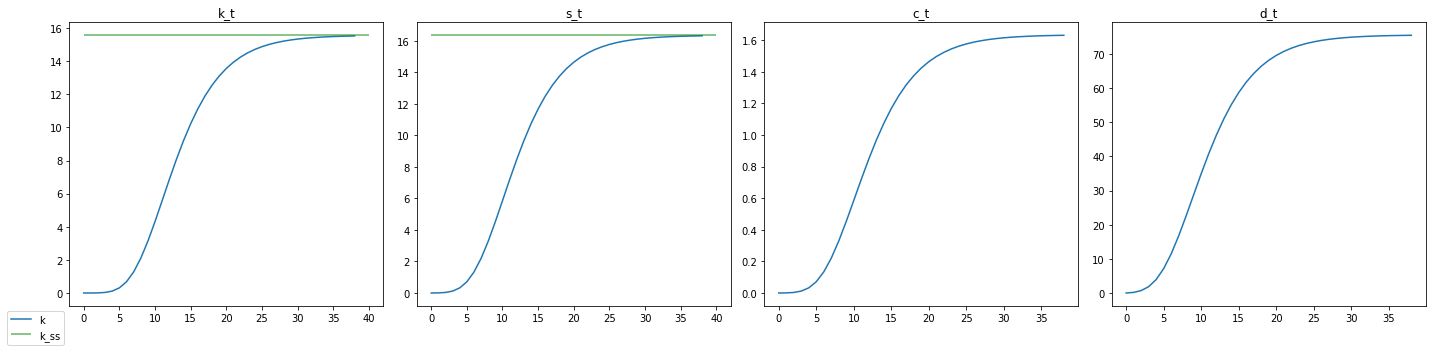

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
title_dict = {0: 'k_t', 1: 's_t', 2: 'c_t', 3: 'd_t'}

for i in range(0, z):
    ax[i].plot(out[i])
    ax[i].set_title(title_dict[i])

ax[1].hlines(make_sopt(_beta, _X, _alpha, 
                       make_kss(_beta, _X, _alpha, 0, _n),
                       _n),
             0, T, color='green', alpha=.6)
    
# plot k_ss
ax[0].hlines(make_kss(_beta, _X, _alpha, 0, _n), 0, T, color='green', alpha=.6)
# ax[0].hlines(make_kgold(_beta, _X, _alpha, 0, _n), 0, T, color='red')
ax[0].legend(['k', 'k_ss', 'k_gold'], bbox_to_anchor=(0,0))

plt.tight_layout()
;